In [1]:
# code adapted from https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33#:~:text=The%20Keras%20ResNet%20got%20to,to%20do%20with%20weight%20initializations.
# import plaidml
# import plaidml.keras
# plaidml.install_backend()
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
NUM_SAMP = 1000
import random
random.seed(10)

from PIL import Image
from glob import glob

# Clean Script
from glob import glob
import tensorflow as tf

from tensorflow.keras.utils import load_img

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model,load_model
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Collect paths to images based on label
nonCancerPaths = glob('imagedata/*/0/*.png')
cancerousPaths = glob('imagedata/*/1/*.png')

# Turn filepaths into image arrays to train a model
def paths_to_image(paths, label, num_samples):
    images = []
    labels = []
    for path in paths[0:num_samples]:
        image = load_img(path)
        image = image.resize([50, 50])
        imgArray = tf.keras.utils.img_to_array(image)
        images.append(imgArray)
        labels.append(label)
    return [images[0: num_samples], labels[0: num_samples]]
nonCancerImages = paths_to_image(nonCancerPaths, 0, len(nonCancerPaths))
cancerImages = paths_to_image(cancerousPaths, 1, len(cancerousPaths))










2023-03-19 15:28:10.558619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# split images into train, val, test
allImages = nonCancerImages[0] + cancerImages[0]
allLabels = nonCancerImages[1] + cancerImages[1]

x_train, x_toSplit, y_train, y_toSplit = train_test_split(allImages, allLabels, test_size=.5, stratify= allLabels, random_state = 10)
x_val, x_test, y_val, y_test = train_test_split(x_toSplit, y_toSplit, test_size=.5, stratify=y_toSplit, random_state = 10)


#function which rotates image a certain number of degrees = to rotation
def rotate_image(X, y, rotation, num_to_rotate = None):
    rotatedImages = []
    labels = []
    cancerX = X[y==1]
    if num_to_rotate is not None and num_to_rotate < len(cancerX):
        cancerX = cancerX[0: num_to_rotate]
    for img in cancerX:
        image = tf.keras.utils.array_to_img(img)
        image = image.resize([50, 50])
        rotateimg = image.rotate(rotation)
        imgArray = tf.keras.utils.img_to_array(rotateimg)
        rotatedImages.append(imgArray)
        labels.append(1)
    return [rotatedImages, labels]


train90 = rotate_image(np.array(x_train), np.array(y_train), 90)
train180 = rotate_image(np.array(x_train), np.array(y_train), 180, 20583)


In [3]:
print("Number of cancer images in training set", str((len(train180[0]) + len(train90[0])) + sum(y_train)))
print("Number of benign images in training set", str(len(y_train) - sum(y_train)))

Number of cancer images in training set 99369
Number of benign images in training set 99369


In [4]:
x_train = np.array(x_train)
train90[0] = np.array(train90[0])
train180[0] = np.array(train180[0])
y_train = np.array(y_train)
train90[1] = np.array(train90[1])
train180[1] = np.array(train180[1])

training_x = np.concatenate((x_train, train90[0], train180[0]), axis=0)
training_y = np.concatenate((y_train, train90[1], train180[1]))


# Shuffle order
zipper = list(zip(training_x, training_y))
random.shuffle(zipper)
training_x, training_y = zip(*zipper)

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

# Because of computing power problems we subset to the first 10000 images in training
training_x = training_x[0:10000]
training_y = training_y[0:10000]

train_iterator = datagen.flow(np.array(training_x), np.array(training_y))
val_iterator = datagen.flow(np.array(x_val), np.array(y_val))


2023-03-19 15:35:49.736084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


FITTING
Epoch 1/15
313/313 [==============================] - 587s 2s/step - loss: 0.6879 - accuracy: 0.5423 - val_loss: 0.7133 - val_accuracy: 0.3774
Epoch 2/15
313/313 [==============================] - 573s 2s/step - loss: 0.5206 - accuracy: 0.7711 - val_loss: 0.4840 - val_accuracy: 0.7745
Epoch 3/15
313/313 [==============================] - 582s 2s/step - loss: 0.4382 - accuracy: 0.8049 - val_loss: 0.4410 - val_accuracy: 0.7873
Epoch 4/15
313/313 [==============================] - 602s 2s/step - loss: 0.4194 - accuracy: 0.8130 - val_loss: 0.4581 - val_accuracy: 0.7849
Epoch 5/15
313/313 [==============================] - 587s 2s/step - loss: 0.3996 - accuracy: 0.8238 - val_loss: 0.4802 - val_accuracy: 0.7649
Epoch 6/15
313/313 [==============================] - 562s 2s/step - loss: 0.3681 - accuracy: 0.8402 - val_loss: 0.4024 - val_accuracy: 0.8252
Epoch 7/15
313/313 [==============================] - 573s 2s/step - loss: 0.3349 - accuracy: 0.8586 - val_loss: 0.4632 - val_accuracy

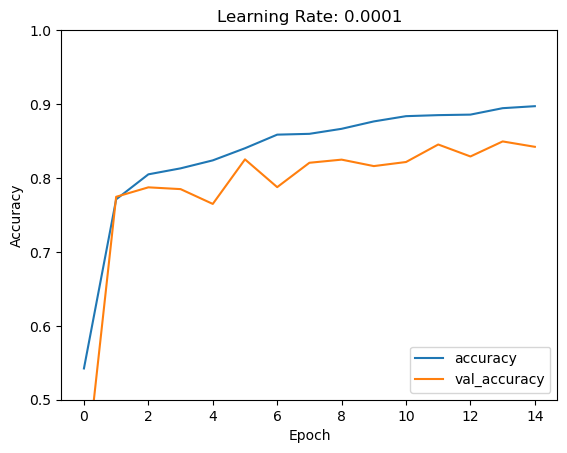

In [5]:
# #Learning rates above .01 are not useful

# learning_rates = [.0001, .0005, .001, .005, .01, .05, .1]

# for lr in learning_rates:
#     model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
#     adam = Adam(learning_rate=lr)
#     model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

#     print("FITTING")
#     history = model.fit(np.array(x_train), np.array(y_train), epochs=10, validation_data=(np.array(x_test), np.array(y_test)))
#     plt.plot(history.history['accuracy'], label='accuracy')
#     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.ylim([0.5, 1])
#     plt.legend(loc='lower right')
#     plt.title("Learning Rate: " + str(lr))
#     plt.show()



# LR = .0001 achieves the highest validation accuracy
# Increase number of epochs to see if more epochs further increases val error
LR = .0001
model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
adam = Adam(learning_rate=LR)
model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

print("FITTING")
history = model.fit(train_iterator, epochs=15, validation_data=val_iterator)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Learning Rate: " + str(LR))
plt.show()



In [ ]:
# LR = .0001 achieves the highest validation accuracy
# Increase number of epochs to see if more epochs further increases val error
# model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
# adam = Adam(learning_rate=.0001)
# model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# print("FITTING")
# history = model.fit(np.array(x_train), np.array(y_train), epochs=15, validation_data=(np.array(x_test), np.array(y_test)))
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')
# plt.title("Learning Rate: " + str(lr))
# plt.show()


In [ ]:
model.summary()

In [8]:
test_iterator = datagen.flow(np.array(x_test), np.array(y_test))

model.evaluate(test_iterator)

2169/2169 [==============================] - 304s 140ms/step - loss: 0.3634 - accuracy: 0.8390


[0.3634363114833832, 0.8390192985534668]

In [15]:
# cancer evaluation
cancer_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 1]), np.array(y_test)[np.array(y_test) == 1])

model.evaluate(cancer_iterator)

616/616 [==============================] - 87s 141ms/step - loss: 0.4926 - accuracy: 0.8092


[0.4926299452781677, 0.8092095255851746]

In [16]:
# benign evaluation

benign_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 0]), np.array(y_test)[np.array(y_test) == 0])

model.evaluate(benign_iterator)




1553/1553 [==============================] - 217s 139ms/step - loss: 0.3122 - accuracy: 0.8508


[0.3122173845767975, 0.8508372902870178]